In [29]:
import sqlite3
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as seb

In [13]:
### LOAD DATA FROM CSV INTO SQL DATABASE
DB_FILE = 'netflix.db'
# if DB file does not exist use the csv data to populate it
if not os.path.exists(DB_FILE):    
    titles = pd.read_csv('titles.csv')
    # make the database connection
    dbcon = sqlite3.connect(DB_FILE)
    # create empty tables with the correct relationships for population with the csv data
    create_titles = '''CREATE TABLE IF NOT EXISTS titles (
                                            id TEXT PRIMARY KEY,
                                            title TEXT,
                                            type TEXT,
                                            description TEXT,
                                            release_year INTEGER,
                                            age_certification TEXT,
                                            runtime INTEGER,
                                            genres TEXT,
                                            production_countries TEXT,
                                            seasons INTEGER,
                                            imdb_id TEXT,
                                            imdb_score INTEGER,
                                            imdb_votes INTEGER,
                                            tmdb_popularity INTEGER,
                                            tmdb_score INTEGER
                                        );'''
    create_people = '''CREATE TABLE IF NOT EXISTS people (
                                            person_id INTEGER PRIMARY KEY,
                                            name TEXT
                                        );'''
    create_role = '''CREATE TABLE IF NOT EXISTS role (
                                            id TEXT NOT NULL,
                                            person_id INTEGER NOT NULL,
                                            character TEXT,
                                            role TEXT,
                                            FOREIGN KEY (id) REFERENCES title(id),
                                            FOREIGN KEY (person_id) REFERENCES people(person_id) 
                                        );'''
    cur = dbcon.cursor() # create the above 3 empty tables
    cur.execute(create_titles)
    cur.execute(create_people)
    cur.execute(create_role)
    # use pandas to read the title data for easy storage into the SQLite db
    titles = pd.read_csv('titles.csv')
    titles.to_sql('titles', con=dbcon, if_exists='append', index=False)
    
    '''
    the credits data is a little harder, since it makes more sense to 
    have a realation table referencing the actor/director in a title.
    Rather than a table with dupes
    '''
    credits = pd.read_csv('credits.csv')
    
    # the IN relationship describes each person's role in a title
    in_relation = credits[['person_id', 'id', 'character', 'role']]
    
    # the new people table is of each unique person (no repeats), more like a lookup
    people = credits.drop(['id', 'character', 'role'], axis=1)
    people.drop_duplicates(keep='first', inplace=True)

    # add both these new tables to the database
    people.to_sql('people', con=dbcon, if_exists='append', index=False)
    in_relation.to_sql('role', con=dbcon, if_exists='append', index=False)
    dbcon.close()


[[1.32556035 0.7733128 ]
 [0.7733128  1.3062808 ]]


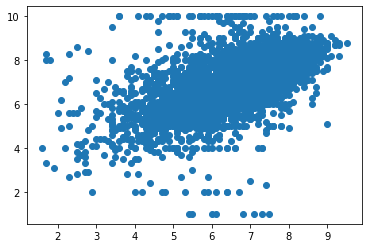

In [63]:
# EDA
dbcon = sqlite3.connect(DB_FILE)
cur = dbcon.cursor()

cur.execute('''
SELECT imdb_score, tmdb_score FROM titles WHERE imdb_score NOT NULL AND tmdb_score NOT NULL
''')
cur.row_factory = lambda cursor, row: list(row)
scores = np.array(cur.fetchall()).T
#print(scores[0])
plt.scatter(scores[0], scores[1])
print(np.cov(scores))

In [ ]:
cur.execute('''
SELECT name, tmdb_score FROM titles WHERE imdb_score NOT NULL AND tmdb_score NOT NULL
''')